# Network Intrusion Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from category_encoders import *

c:\Python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Loading the data set

We will start by extracting feature names from the kddcup names file. Since it does contain any name for the label, we will add a column name 'connection_type' for the labels (target variable).

In [2]:
kddcup_names = open("kddcup.names").read().split('\n')
feature_names = []
for feature_name in kddcup_names[1:]:
    feature_names.append(feature_name.split(':')[0].strip())

feature_names.append("connection_type")

In [3]:
feature_names

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'connection_type']

Load the data sets into dataframes

In [4]:
kddcup_data = pd.read_csv("kddcup.data", names=feature_names, index_col=False)
kddcup_test_data = pd.read_csv("corrected", names=feature_names, index_col=False)

## Data Preprocessing

Now, we will do some preprocessing on the training and test data sets.

In [5]:
kddcup_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
kddcup_data.shape

(4898431, 42)

In [7]:
kddcup_test_data.shape

(311029, 42)

We want to perform numeric encoding on the categorical features. Pandas has a function get_dummies() for this. This function adds additional columns based on the categories present in the feature. To make sure that we have the same number of columns in the train and test sets, we combine the two data sets, perform encoding and then split them back.

In [8]:
data = pd.concat([kddcup_data, kddcup_test_data])

In [9]:
data.shape

(5209460, 42)

In [10]:
pd.unique(data.protocol_type)

array(['tcp', 'udp', 'icmp'], dtype=object)

In [11]:
pd.unique(data.service)

array(['http', 'smtp', 'domain_u', 'auth', 'finger', 'telnet', 'eco_i',
       'ftp', 'ntp_u', 'ecr_i', 'other', 'urp_i', 'private', 'pop_3',
       'ftp_data', 'netstat', 'daytime', 'ssh', 'echo', 'time', 'name',
       'whois', 'domain', 'mtp', 'gopher', 'remote_job', 'rje', 'ctf',
       'supdup', 'link', 'systat', 'discard', 'X11', 'shell', 'login',
       'imap4', 'nntp', 'uucp', 'pm_dump', 'IRC', 'Z39_50', 'netbios_dgm',
       'ldap', 'sunrpc', 'courier', 'exec', 'bgp', 'csnet_ns', 'http_443',
       'klogin', 'printer', 'netbios_ssn', 'pop_2', 'nnsp', 'efs',
       'hostnames', 'uucp_path', 'sql_net', 'vmnet', 'iso_tsap',
       'netbios_ns', 'kshell', 'urh_i', 'http_2784', 'harvest', 'aol',
       'tftp_u', 'http_8001', 'tim_i', 'red_i', 'icmp'], dtype=object)

In [12]:
pd.unique(data.flag)

array(['SF', 'S2', 'S1', 'S3', 'OTH', 'REJ', 'RSTO', 'S0', 'RSTR',
       'RSTOS0', 'SH'], dtype=object)

In [13]:
# data.to_csv('combined_data.csv',index=False)

In [37]:
data_x = data.drop("connection_type", axis=1)

In [54]:
data_x

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,udp,private,SF,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311025,0,udp,private,SF,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311026,0,udp,private,SF,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311027,0,udp,private,SF,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0


In [64]:
enc = OrdinalEncoder().fit(data_x)

In [65]:
data_encoded = enc.transform(data_x)

In [66]:
data_encoded

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,1,1,215,45076,0,0,0,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0,1,1,1,162,4528,0,0,0,0,...,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,236,1228,0,0,0,0,...,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0
3,0,1,1,1,233,2032,0,0,0,0,...,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0
4,0,1,1,1,239,486,0,0,0,0,...,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,2,13,1,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311025,0,2,13,1,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311026,0,2,13,1,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
311027,0,2,13,1,105,147,0,0,0,0,...,255,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0


In [79]:
data_encoded["connection_type"] = data["connection_type"].values

In [80]:
data_encoded

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,1,1,1,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,1,1,1,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,1,1,1,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,1,1,1,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,1,1,1,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,2,13,1,105,147,0,0,0,0,...,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311025,0,2,13,1,105,147,0,0,0,0,...,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311026,0,2,13,1,105,147,0,0,0,0,...,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311027,0,2,13,1,105,147,0,0,0,0,...,255,1.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,normal.


In [81]:
import pickle
filehandler = open("enc.obj","wb")
pickle.dump(enc,filehandler)
filehandler.close()

In [82]:
train_data = pd.DataFrame(data_encoded.iloc[0:4898431,:])
train_data.shape

(4898431, 42)

In [83]:
test_data = pd.DataFrame(data_encoded.iloc[4898431:,:])
test_data.shape

(311029, 42)

Then, we check for missing values in the data set.

In [84]:
train_data.isnull().any().any()

False

There are no missing values in the data set.

In [85]:
data.connection_type.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: connection_type, dtype: object

We observe that there is an extra '.' in the 'connection_type' column after the connection type. For better visualization and interpretation, we remove the '.'.

In [86]:
train_data['connection_type'] = train_data['connection_type'].apply(lambda x : str(x)[:-1])
train_data.connection_type.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: connection_type, dtype: object

Next, we check for duplicate rows and remove them from the training data set.

In [87]:
train_data = train_data.drop_duplicates()
train_data.shape

(1074992, 42)

Originally, we had 4898431 rows in the data set. After removing the duplicates, we have 1074992 rows. This shows that there were too many redundant rows in the data set. Since this data is a TCP dump, having same values is very much expected.

Next, we scale all the numeric features between 0 and 1. We are given a detailed description of the data set features denoting which features are continuous and which are discrete along with the data types.

In [88]:
# numeric_features = train_data.dtypes[train_data.dtypes != "object"].index
# min_max_scaler = MinMaxScaler().fit(train_data[numeric_features])
# train_data[numeric_features] = min_max_scaler.transform(train_data[numeric_features])
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,1,1,1,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,1,1,1,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,1,1,1,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal
3,0,1,1,1,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal
4,0,1,1,1,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal


Here, we are dealing with binary classification i.e. whether a connection is an attack or not. In our data set, columns are labelled as either 'normal' or as the attack type. So we need to need to denote normal connections as one class type and all the attack types as another class. The new class label would be 0 if the connection is normal and 1 if it is an attack.

In [90]:
train_data["label"] = train_data["connection_type"] != 'normal'
train_data["label"] = train_data["label"].apply(lambda x : int(x))
train_data.label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [91]:
train_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type,label
0,0,1,1,1,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal,0
1,0,1,1,1,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal,0
2,0,1,1,1,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal,0
3,0,1,1,1,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal,0
4,0,1,1,1,239,486,0,0,0,0,...,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,1,1,1,212,2288,0,0,0,0,...,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal,0
4898427,0,1,1,1,219,236,0,0,0,0,...,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal,0
4898428,0,1,1,1,218,3610,0,0,0,0,...,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal,0
4898429,0,1,1,1,219,1234,0,0,0,0,...,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal,0


## Exploratory Analysis

Let's see how the attack types are distributed over the data set.

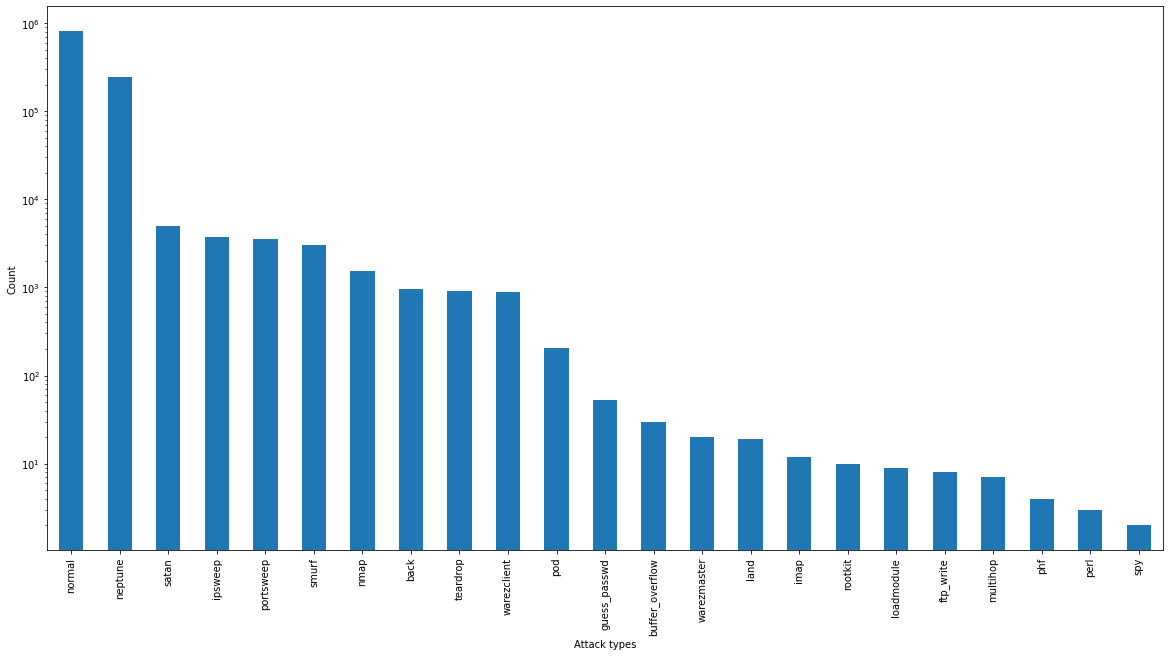

In [92]:
plt.figure(figsize=(20,10))
plt.yscale("log")
train_data["connection_type"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("Attack types")
plt.show()

Let's see how the labels are distributed over the data set.

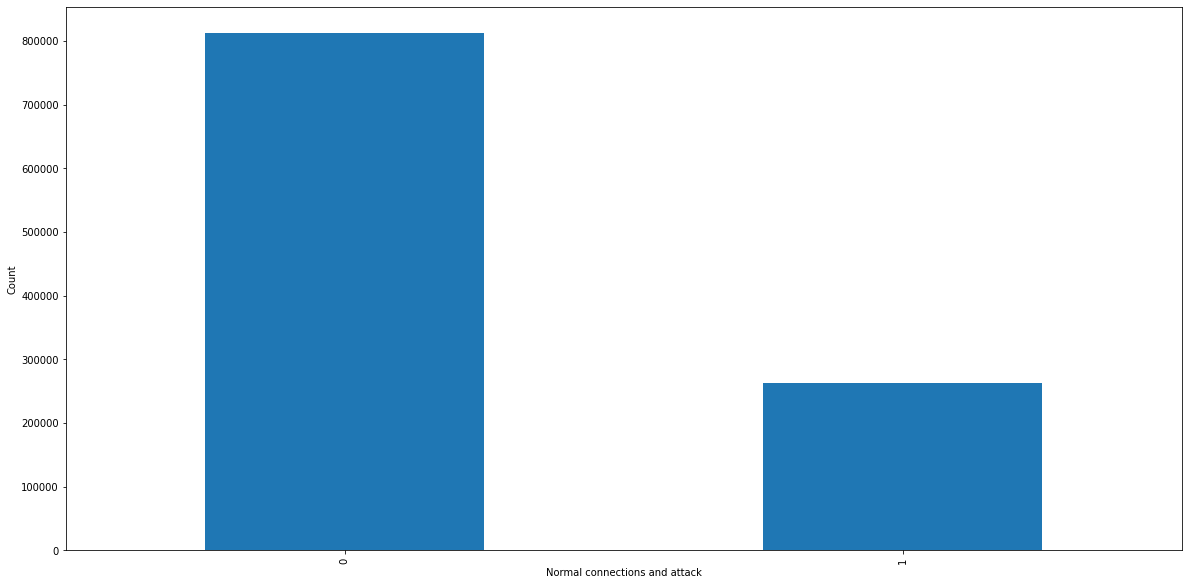

In [93]:
plt.figure(figsize=(20,10))
train_data["label"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("Normal connections and attack")
plt.show()

We can see that the number of normal connections is significantly larger the number of attacks. Though this is expected and makes sense, it would not be feasible to use accuracy as the only metric while evaluating a model.

The other thing worth noting is that we have to be careful about false negatives. We cannot afford to have a connection identified as not being malicious when it is an attack. For this, we would plot the ROC curve and use Area Under Curve as an evaluation metric.

In [94]:
DF_normal = train_data[train_data["label"] == 0]
DF_attacked = train_data[train_data["label"] == 1]

In [95]:
def plotHists(i, threshold = 0):
    plt.figure(figsize = [10,10])
    plt.subplot(2, 1, 1)
    plt.title('Histogram for '+i+': Normal connections')
    plt.yscale('log')
    plt.hist(DF_normal[DF_normal[i] > threshold][i], bins=300, color='green')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.subplot(2, 1, 2)
    plt.title('Histogram for '+i+': Attacked connections')
    plt.yscale('log')
    plt.hist(DF_attacked[DF_attacked[i] > threshold][i], bins = 300, color='red')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.show()

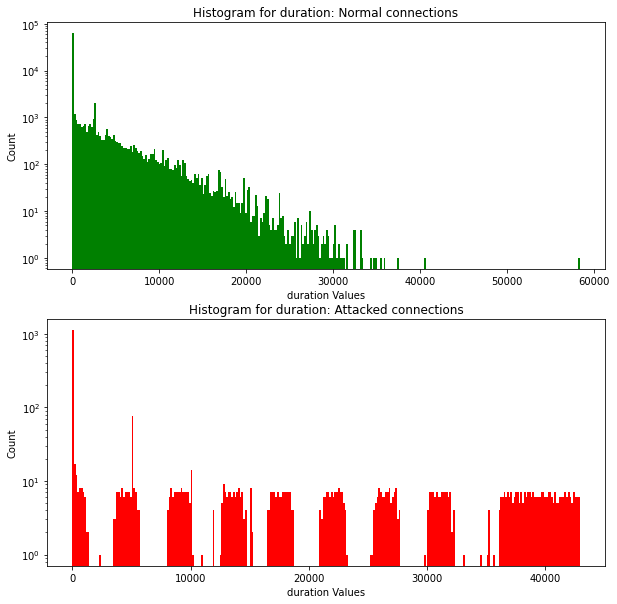

In [96]:
plotHists("duration")

We observe that the duration is concentrated towards smaller values in normal connections. Even though the duration values for attacks are spread over the entire range of values, we can conclude that if a connection's duration is more than 0.5, it might probably be an attack.

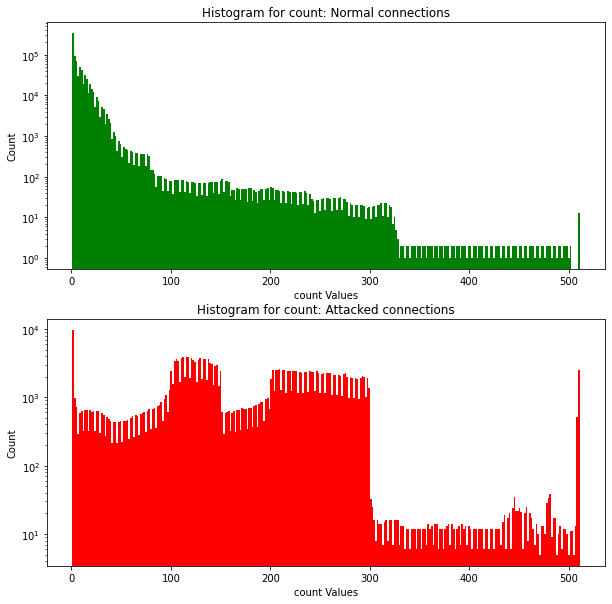

In [97]:
plotHists("count")

The count of number of connections to the same host is again concentrated at smaller values for normal connections. However, for attacks, there is a surge between values 0.2 and 0.6 which can be indicative of a malicious connection.

## Model Training

Now, we will drop the column "connection_type" since we no longer need it.

In [98]:
train_data = train_data.drop("connection_type", axis=1)
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,1,1,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0,1,1,1,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0
2,0,1,1,1,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0
3,0,1,1,1,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0
4,0,1,1,1,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0


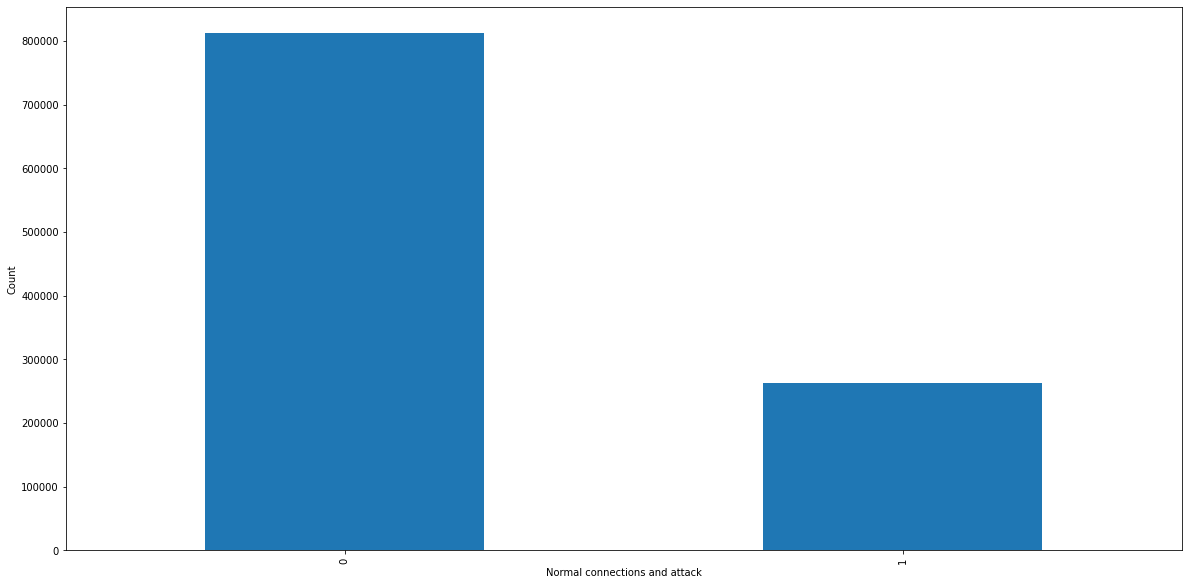

In [99]:
plt.figure(figsize=(20,10))
train_data["label"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("Normal connections and attack")
plt.show()

## Since the dataset is imbalanced, we need to balance it.
## We use SMOTE algorithm for balancing. (Synthetic data generation)

In [100]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, Y = oversample.fit_resample(train_data.iloc[:,:-1], train_data["label"])

## We will now build Random Forest classifiers and see how they perform.

In [101]:
random_forest = RandomForestClassifier().fit(train_data.iloc[:,:-1], train_data["label"])
random_forest

RandomForestClassifier()

In [102]:
random_forest_balanced = RandomForestClassifier().fit(X, Y)
random_forest_balanced

RandomForestClassifier()

## Model Evaluation

To evaluate our classifiers, we will preprocess the test data as we did we our training data.

In [103]:
test_data.shape

(311029, 42)

We make sure there are no missing values.

In [104]:
test_data.isnull().any().any()

False

We will map and scale the features similarly.

In [105]:
test_data['connection_type'] = test_data['connection_type'].apply(lambda x : str(x)[:-1])
numeric_features = test_data.dtypes[test_data.dtypes != "object"].index
# test_data[numeric_features] = min_max_scaler.transform(test_data[numeric_features])
test_data["label"] = test_data["connection_type"] != 'normal'
test_data["label"] = test_data["label"].apply(lambda x : int(x))
test_data = test_data.drop("connection_type", axis=1)
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,2,13,1,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0,2,13,1,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0
2,0,2,13,1,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0
3,0,2,13,1,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,1
4,0,2,13,1,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,1


We will test the models on our test data set and determine the most suited model for our problem.

In [106]:
print ("For Random Forest classifier:\nAccuracy Score is: ")
accuracy_score(test_data["label"], random_forest.predict(test_data.iloc[:,:-1])) * 100

For Random Forest classifier:
Accuracy Score is: 


92.60583418266464

#### accuracy is 92.6% for normal random forest model

In [107]:
from sklearn.metrics import classification_report

In [108]:
print(classification_report(test_data["label"], random_forest.predict(test_data.iloc[:,:-1])))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029



In [109]:
print ("For Random Forest classifier:\nAccuracy Score is: ")
accuracy_score(test_data["label"], random_forest_balanced.predict(test_data.iloc[:,:-1])) * 100

For Random Forest classifier:
Accuracy Score is: 


92.71707782875552

#### accuracy is 92.71% for normal random forest model

In [110]:
print(classification_report(test_data["label"], random_forest_balanced.predict(test_data.iloc[:,:-1])))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029



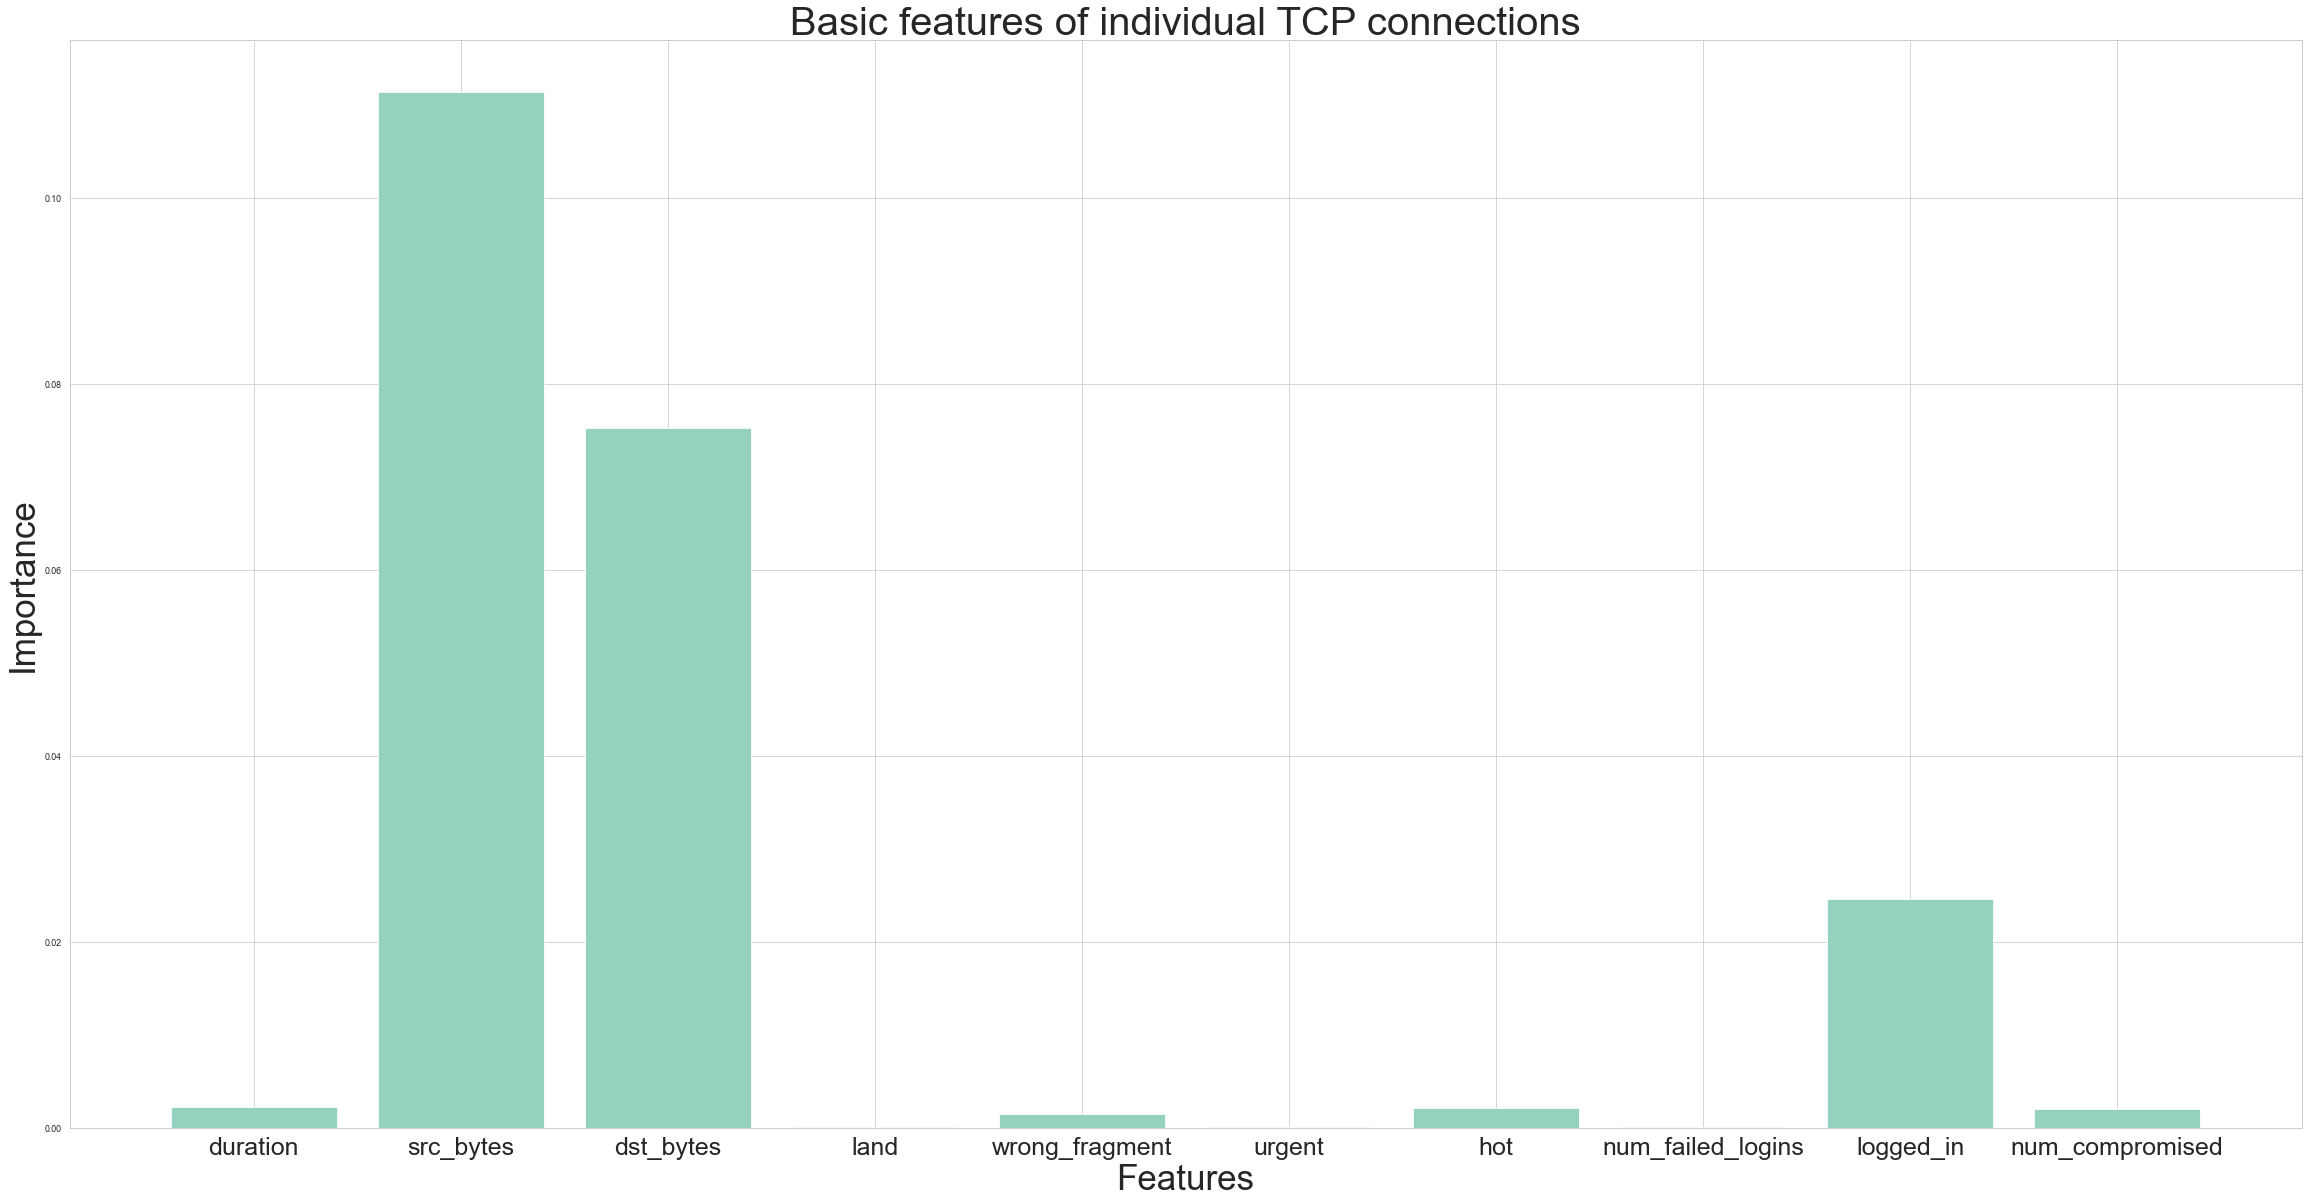

In [62]:
y_pos = np.arange(len(train_data.iloc[:,0:10].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest_balanced.feature_importances_[0:10], align='center')
plt.xticks(y_pos, train_data.iloc[:,0:10].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Basic features of individual TCP connections", fontsize=40)
plt.show()

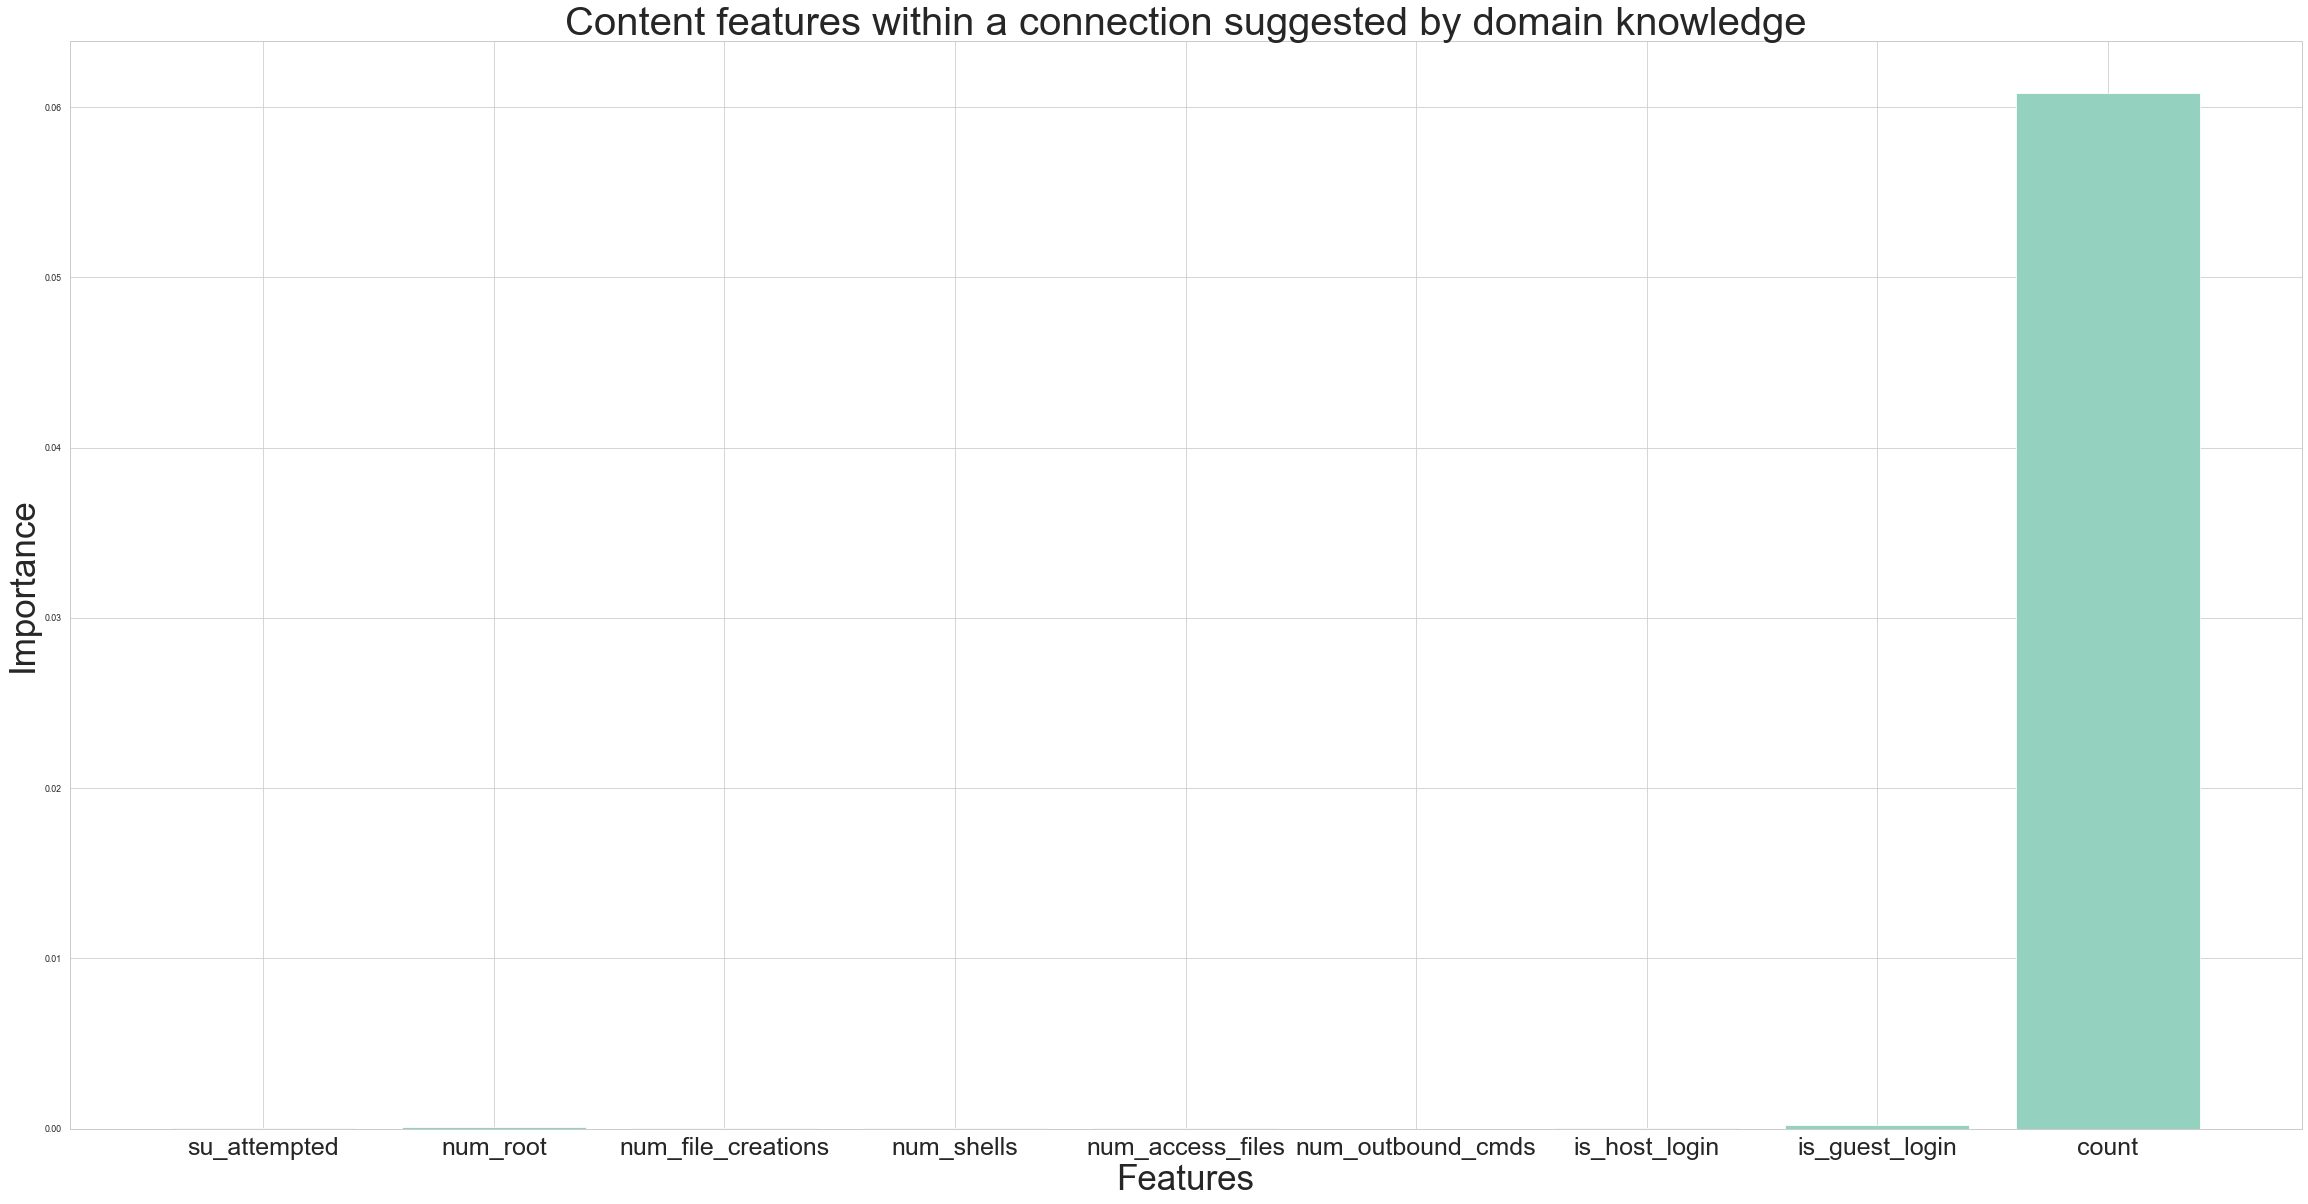

In [60]:
y_pos = np.arange(len(train_data.iloc[:,11:20].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest_balanced.feature_importances_[11:20], align='center')
plt.xticks(y_pos, train_data.iloc[:,11:20].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Content features within a connection suggested by domain knowledge", fontsize=40)
plt.show()

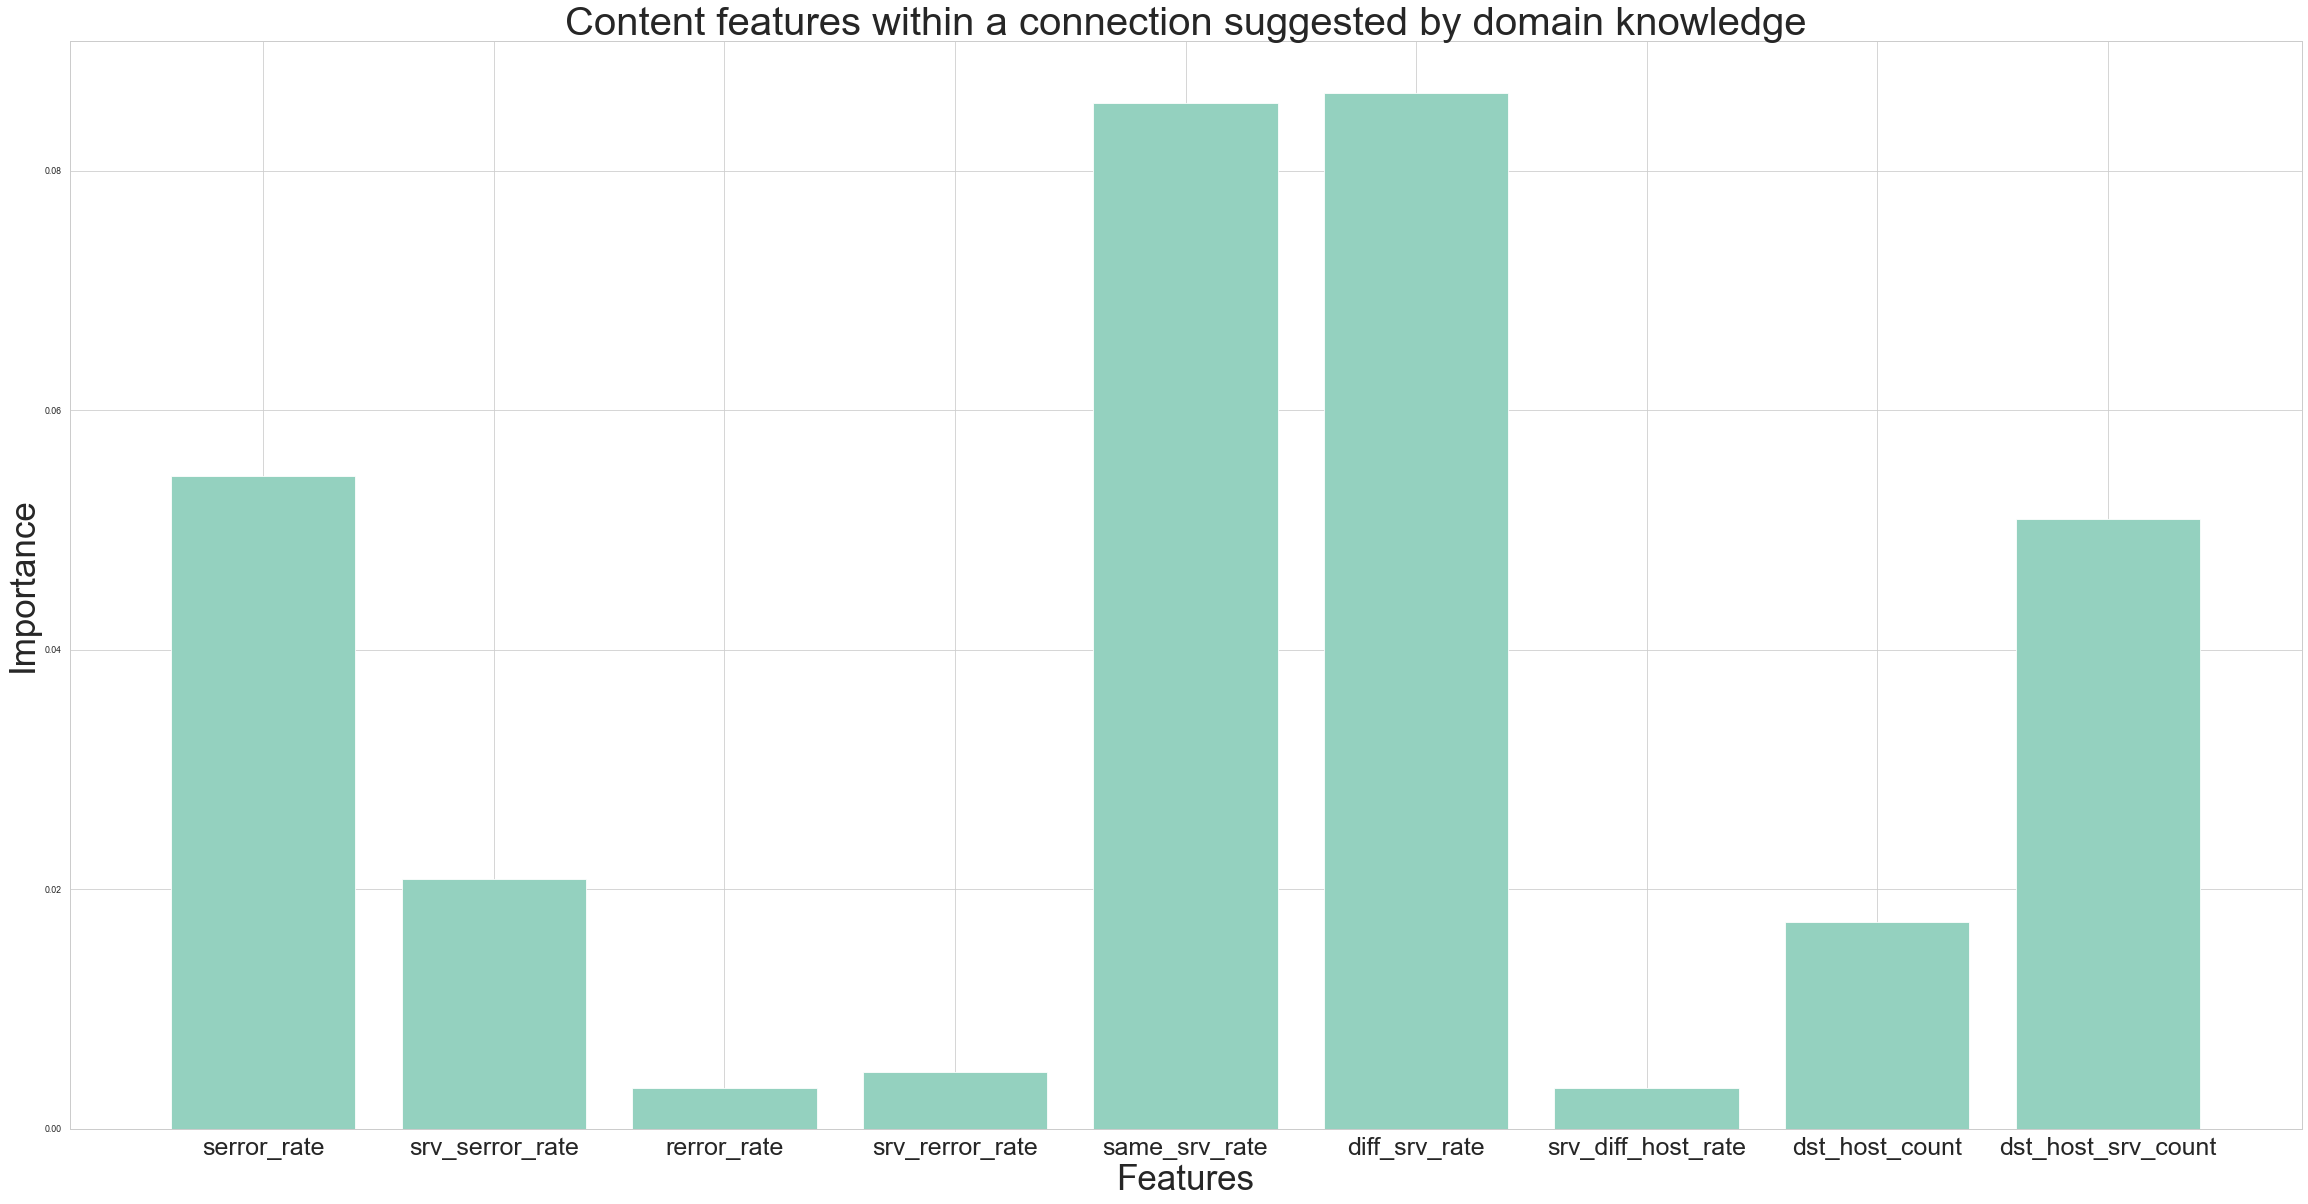

In [65]:
y_pos = np.arange(len(train_data.iloc[:,21:30].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest_balanced.feature_importances_[21:30], align='center')
plt.xticks(y_pos, train_data.iloc[:,21:30].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Content features within a connection suggested by domain knowledge", fontsize=40)
plt.show()

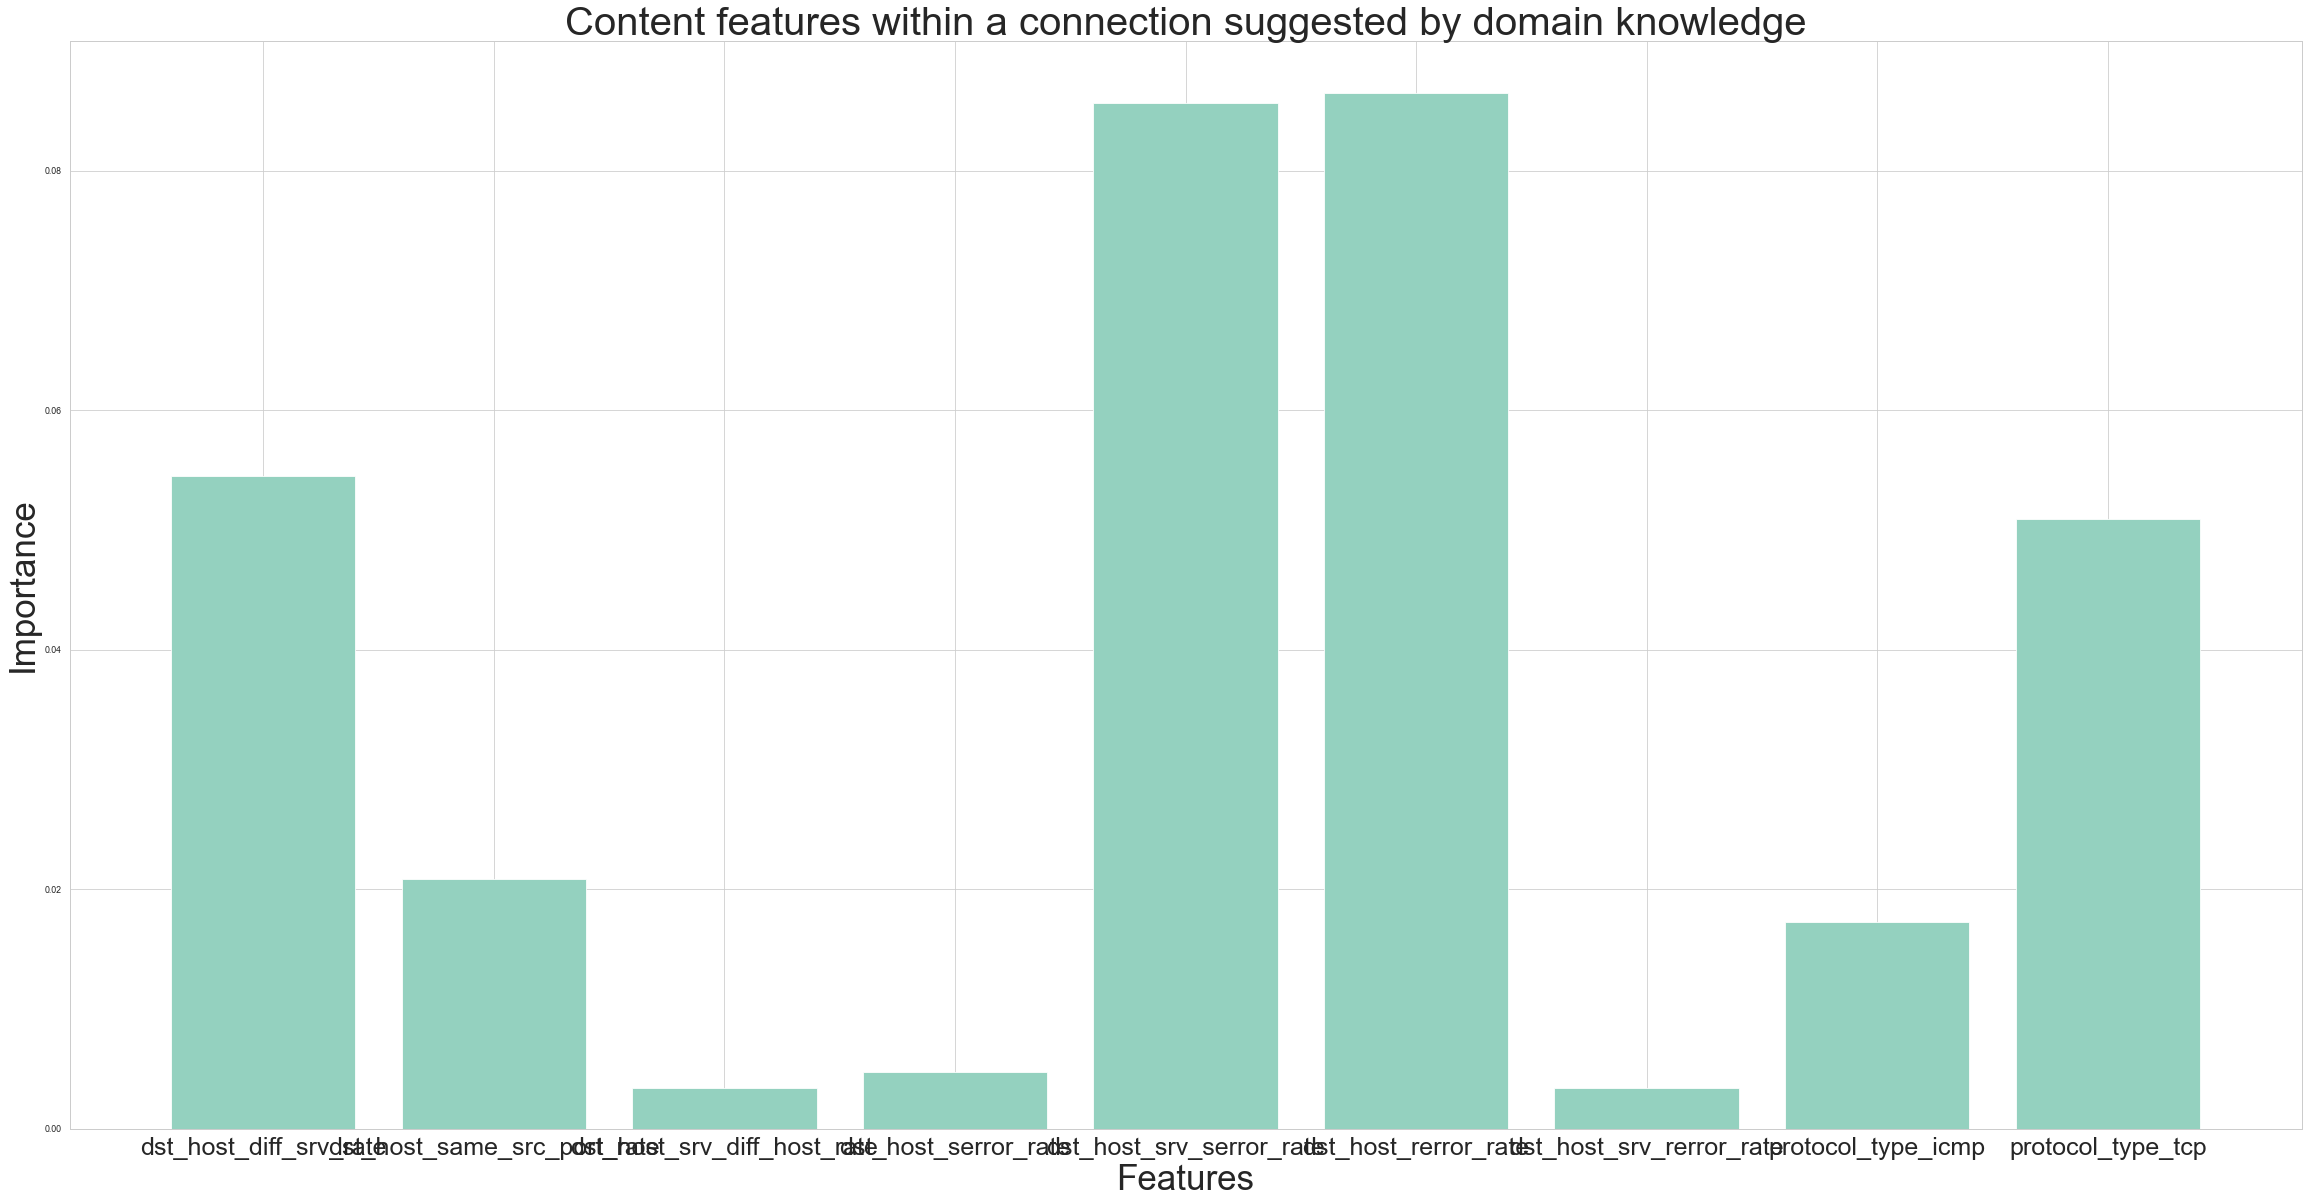

In [66]:
y_pos = np.arange(len(train_data.iloc[:,31:40].columns))
plt.figure(figsize=(40, 20))
plt.bar(y_pos, random_forest_balanced.feature_importances_[21:30], align='center')
plt.xticks(y_pos, train_data.iloc[:,31:40].columns, fontsize=25)
plt.ylabel("Importance", fontsize=35)
plt.xlabel("Features", fontsize=35)
plt.title("Content features within a connection suggested by domain knowledge", fontsize=40)
plt.show()

For Random Forest, the traffic features of the connections are more important and predictive than others

### Saving our model for future predictions

In [111]:
import pickle
pickle.dump(random_forest_balanced, open('balanced_random_forest_model_final.pkl','wb'))